#  library

main() 함수 내 crawler() 함수 수행

In [1]:
 # -*- coding: utf-8 -*-
from bs4 import BeautifulSoup
from datetime import datetime
import requests
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
"""
fname = '한국행정구역분류_2022.1.1.기준.xlsx'
data_region = pd.read_excel(fname, sheet_name = [1], skiprows=2, dtype={'대분류':str, '중분류':str, '소분류':str})
data_region[1].drop('Unnamed: 0', axis=1, inplace=True)
data_citydo_all = data_region[1]['시도'][1:]
data_citydo_unique = data_citydo_all.unique()
booleanArray1 = [not pd.isnull(number) for number in data_citydo_unique]
data_citydo_unique_notna = data_citydo_unique[booleanArray1]
data_citydo_unique_notna
data_citygungu_all = data_region[1]['시군구'][1:]
data_citygungu_unique = data_citygungu_all.unique()
data_citygungu_unique
"""

"\nfname = '한국행정구역분류_2022.1.1.기준.xlsx'\ndata_region = pd.read_excel(fname, sheet_name = [1], skiprows=2, dtype={'대분류':str, '중분류':str, '소분류':str})\ndata_region[1].drop('Unnamed: 0', axis=1, inplace=True)\ndata_citydo_all = data_region[1]['시도'][1:]\ndata_citydo_unique = data_citydo_all.unique()\nbooleanArray1 = [not pd.isnull(number) for number in data_citydo_unique]\ndata_citydo_unique_notna = data_citydo_unique[booleanArray1]\ndata_citydo_unique_notna\ndata_citygungu_all = data_region[1]['시군구'][1:]\ndata_citygungu_unique = data_citygungu_all.unique()\ndata_citygungu_unique\n"

# 크롤링

- 크롤링 해오는 것 : 링크,제목,신문사,내용요약본
- 키워드 : 붉은물, 적수, 유충


- 내용요약본  -> 정제 작업 필요
- 리스트 -> 딕셔너리 -> df -> 엑셀로 저장

In [2]:
cos = []

In [102]:
flag_save = 0

maxpage = input("최대 크롤링할 페이지 수 입력하시오: ")  # 1
sort = input("뉴스 검색 방식 입력(관련도순=0  최신순=1  오래된순=2): ") # 0

s_date = '2019.08.08' # 2019.05.10  2019.05.20  2019.05.30  2019.06.09  2019.06.19  2019.06.29  2019.07.09  2019.07.19  2019.07.29  2019.08.08
e_date = '2019.08.17' # 2019.05.19  2019.05.29  2019.06.08  2019.06.18  2019.06.28  2019.07.08  2019.07.18  2019.07.28  2019.08.07  2019.08.17

#각 크롤링 결과 저장하기 위한 리스트 선언
title_text=[]
link_text=[]
source_text=[]
contents_text=[]
result={}

#엑셀로 저장하기 위한 변수
#RESULT_PATH ='C:/'  #결과 저장할 경로
now = datetime.now() #파일이름 현 시간으로 저장하기

#내용 정제화 함수
def contents_cleansing(contents):
    first_cleansing_contents = re.sub('<dl>.*?</a> </div> </dd> <dd>', '',str(contents)).strip()  #앞에 필요없는 부분 제거
    second_cleansing_contents = re.sub('<ul class="relation_lst">.*?</dd>', '', first_cleansing_contents).strip()#뒤에 필요없는 부분 제거 (새끼 기사)
    third_cleansing_contents = re.sub('<.+?>', '', second_cleansing_contents).strip()
    contents_text.append(third_cleansing_contents)
    #print(contents_text)

#크롤링 시작
list_region = ['인천']

for region in list_region:
  list_keyword = ['수돗물 적수']
  for keyword in list_keyword:
    query = region +' ' + keyword
    s_from = s_date.replace(".","")
    e_to = e_date.replace(".","")
    page = 1
    maxpage_t =(int(maxpage)-1)*10+1   # 11= 2페이지 21=3페이지 31=4페이지  ...81=9페이지 , 91=10페이지, 101=11페이지
    while page <= maxpage_t:
        url = "https://search.naver.com/search.naver?where=news&query=" + query + "&sort="+sort+"&ds=" + s_date + "&de=" + e_date + "&nso=so%3Ar%2Cp%3Afrom" + s_from + "to" + e_to + "%2Ca%3A&start=" + str(page)
        response = requests.get(url)
        html = response.text

        #뷰티풀소프의 인자값 지정
        soup = BeautifulSoup(html, 'html.parser')

        #<a>태그에서 제목과 링크주소 (a 태그 중 class 명이 news_tit인 것)
        atags = soup.find_all('a', 'news_tit')
        for atag in atags:
            title = atag.get('title')
            title_text.append(title)     #제목
            link_text.append(atag['href'])   #링크주소

        #신문사 추출 (a 태그 중 class 명이 info press인 것)
        source_lists = soup.find_all('a', 'info press')
        for source_list in source_lists:
            source_text.append(source_list.text)    #신문사

        #본문요약본 (a 태그 중 class 명이 api_txt_lines dsc_txt_wrap인 것)
        contents_lists = soup.find_all('a','api_txt_lines dsc_txt_wrap')
        for contents_list in contents_lists:
            contents_cleansing(contents_list) #본문요약 정제화

        #모든 리스트 딕셔너리형태로 저장
        result= {"title":title_text ,  "source" : source_text ,"contents": contents_text ,"link":link_text }
        df = pd.DataFrame(result)  #df로 변환
        page += 10
        print(df)

if flag_save == 1:
    # 새로 만들 파일이름 지정
    outputFileName = '%s-%s-%s %s시 %s분 %s초 merging' % (now.year, now.month, now.day, now.hour, now.minute, now.second)
    df.to_excel(outputFileName+'.xlsx',sheet_name='sheet1')
    #df.to_csv(outputFileName+'.csv', mode='w')

최대 크롤링할 페이지 수 입력하시오: 1
뉴스 검색 방식 입력(관련도순=0  최신순=1  오래된순=2): 0
                                       title      source  \
0             붉은 수돗물 피해 주민들 "정상화 아냐"…집단소송 예고  연합뉴스언론사 선정   
1                        수돗물 적수 이어 이번엔 역한 냄새      파이낸셜뉴스   
2              포항시, 수돗물 여과 실험 및 상수도관 이토작업 실시       NSP통신   
3           인천 '붉은 수돗물' 피해보상 착수…12~30일 신청 접수         뉴스1   
4               '적수 사태 진상규명' 인천시의회 특위 행정사무조사        경인일보   
5          인천 '붉은 수돗물' 피해보상…사흘간 2333명 4억원 접수        경향신문   
6               인천시의회 특위, 붉은 수돗물 조사 호통치기에 그쳐        중부일보   
7  인천시의회, '붉은 수돗물' 특위...탁도계 업체 "탁도계 고장 사실아냐"        경인방송   
8                        인천시, 수돗물 적수 피해보상 착수      파이낸셜뉴스   
9        인천 붉은 수돗물 피해주민들 “피해보상 청구서가 서약서냐” 발끈        한국경제   

                                            contents  \
0  주민대책위, 인천시 발표 보상 계획 철회·재논의 요구 '인천 붉은 수돗물'(적수) ...   
1  적수 수돗물로 피해를 줬던 인천지역 수돗물에서 이번에는 흙냄새와 곰팡이 냄새가 발생...   
2  막여과 시험이란 수돗물 1리터를 공극 0.45㎛ 여과지에 걸러서 여과된 상태(변색 ...   
3  인천시가 ‘붉은 수돗물’(적수) 피해보상 절차에 착수한다. 시는 오는 12~30일 ...  

In [103]:
list_search = ' '.join(list_region) + ' ' + ' '.join(list_keyword)
dfNew = pd.Series(list_search)
df_tfidf_base = df['contents'].append(dfNew,ignore_index=True)

corpus = df_tfidf_base
corpus

C:\Users\qpflw\AppData\Local\Temp/ipykernel_25732/123471369.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tfidf_base = df['contents'].append(dfNew,ignore_index=True)


0     주민대책위, 인천시 발표 보상 계획 철회·재논의 요구 '인천 붉은 수돗물'(적수) ...
1     적수 수돗물로 피해를 줬던 인천지역 수돗물에서 이번에는 흙냄새와 곰팡이 냄새가 발생...
2     막여과 시험이란 수돗물 1리터를 공극 0.45㎛ 여과지에 걸러서 여과된 상태(변색 ...
3     인천시가 ‘붉은 수돗물’(적수) 피해보상 절차에 착수한다. 시는 오는 12~30일 ...
4     13일 오전 인천시의회에서 열린 '수돗물 적수 사고 행정사무조사'에서 전·현직 상수...
5     인천 ‘붉은 수돗물’ 사태로 인한 피해보상 접수가 사흘만에 4000여 건이 넘은 것...
6     윤상순기자 인천 수돗물 적수 사태와 관련해 인천시의회 특별위원회 소속 의원들이 전 ...
7     (앵커)환경부가 인천 '붉은 수돗물' 사태의 원인으로 꼽은 '탁도계 고장'이 사실이...
8     인천시는 수돗물 적수(붉은 물) 발생 2개월 만에 주민들에게 피해 보상을 진행한다....
9     시는 지난 5일 적수사태 정상화를 선언하면서 서구·영종도·강화 등 피해지역의 상하수...
10                                            인천 수돗물 적수
dtype: object

In [104]:
df

,title,source,contents,link
0,"붉은 수돗물 피해 주민들 ""정상화 아냐""…집단소송 예고",연합뉴스언론사 선정,"주민대책위, 인천시 발표 보상 계획 철회·재논의 요구 '인천 붉은 수돗물'(적수) ...",http://yna.kr/AKR20190811025500065?did=1195m
1,수돗물 적수 이어 이번엔 역한 냄새,파이낸셜뉴스,적수 수돗물로 피해를 줬던 인천지역 수돗물에서 이번에는 흙냄새와 곰팡이 냄새가 발생...,http://www.fnnews.com/news/201908131312234449
2,"포항시, 수돗물 여과 실험 및 상수도관 이토작업 실시",NSP통신,막여과 시험이란 수돗물 1리터를 공극 0.45㎛ 여과지에 걸러서 여과된 상태(변색 ...,http://www.nspna.com/news/?mode=view&newsid=37...
3,인천 '붉은 수돗물' 피해보상 착수…12~30일 신청 접수,뉴스1,인천시가 ‘붉은 수돗물’(적수) 피해보상 절차에 착수한다. 시는 오는 12~30일 ...,http://news1.kr/articles/?3691442
4,'적수 사태 진상규명' 인천시의회 특위 행정사무조사,경인일보,13일 오전 인천시의회에서 열린 '수돗물 적수 사고 행정사무조사'에서 전·현직 상수...,http://www.kyeongin.com/main/view.php?key=2019...
5,인천 '붉은 수돗물' 피해보상…사흘간 2333명 4억원 접수,경향신문,인천 ‘붉은 수돗물’ 사태로 인한 피해보상 접수가 사흘만에 4000여 건이 넘은 것...,http://news.khan.co.kr/kh_news/khan_art_view.h...
6,"인천시의회 특위, 붉은 수돗물 조사 호통치기에 그쳐",중부일보,윤상순기자 인천 수돗물 적수 사태와 관련해 인천시의회 특별위원회 소속 의원들이 전 ...,http://www.joongboo.com/news/articleView.html?...
7,"인천시의회, '붉은 수돗물' 특위...탁도계 업체 ""탁도계 고장 사실아냐""",경인방송,(앵커)환경부가 인천 '붉은 수돗물' 사태의 원인으로 꼽은 '탁도계 고장'이 사실이...,http://www.ifm.kr/news/262814
8,"인천시, 수돗물 적수 피해보상 착수",파이낸셜뉴스,인천시는 수돗물 적수(붉은 물) 발생 2개월 만에 주민들에게 피해 보상을 진행한다....,http://www.fnnews.com/news/201908090913374170
9,인천 붉은 수돗물 피해주민들 “피해보상 청구서가 서약서냐” 발끈,한국경제,시는 지난 5일 적수사태 정상화를 선언하면서 서구·영종도·강화 등 피해지역의 상하수...,https://www.hankyung.com/society/article/20190...


# 벡터화

In [105]:
tfidfv = TfidfVectorizer().fit(corpus)
tfidfv_array = tfidfv.transform(corpus).toarray()

In [106]:
tfidfv_array

array([[0.13730786, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.17280971],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.1384918 , 0.        , 0.        , ..., 0.        , 0.16202351,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

# 유사도

In [107]:
cos_sim_df = pd.DataFrame(cosine_similarity(tfidfv_array, tfidfv_array)) 
cos_sim_df

,0,1,2,3,4,5,6,7,8,9,10
0,1.000000,0.032696,0.031015,0.128891,0.074173,0.051727,0.051988,0.038579,0.052414,0.048201,0.255986
1,0.032696,1.000000,0.018902,0.015903,0.038992,0.080603,0.020494,0.031958,0.015320,0.021905,0.038900
2,0.031015,0.018902,1.000000,0.009654,0.036255,0.031353,0.025514,0.008605,0.009300,0.004562,0.072042
3,0.128891,0.015903,0.009654,1.000000,0.021329,0.069121,0.010467,0.015320,0.096563,0.082602,0.069859
4,0.074173,0.038992,0.036255,0.021329,1.000000,0.021595,0.039309,0.149771,0.020547,0.016640,0.104355
5,0.051727,0.080603,0.031353,0.069121,0.021595,1.000000,0.020330,0.023979,0.106906,0.064116,0.135682
6,0.051988,0.020494,0.025514,0.010467,0.039309,0.020330,1.000000,0.041164,0.010084,0.038698,0.149835
7,0.038579,0.031958,0.008605,0.015320,0.149771,0.023979,0.041164,1.000000,0.014758,0.024430,0.124681
8,0.052414,0.015320,0.009300,0.096563,0.020547,0.106906,0.010084,0.014758,1.000000,0.068346,0.067300
9,0.048201,0.021905,0.004562,0.082602,0.016640,0.064116,0.038698,0.024430,0.068346,1.000000,0.099181


In [108]:
len_contents = len(cos_sim_df)-1
len_contents

10

In [109]:
cos_sim_df_sorted = cos_sim_df.iloc[len_contents].sort_values(ascending=False)
cos_sim_df_sorted

10    1.000000
0     0.255986
6     0.149835
5     0.135682
7     0.124681
4     0.104355
9     0.099181
2     0.072042
3     0.069859
8     0.067300
1     0.038900
Name: 10, dtype: float64

In [110]:
cos_sim_df_sorted_others = cos_sim_df_sorted[1:]
cos_sim_df_sorted_others

cos_sim_df_sorted_others_sum = cos_sim_df_sorted_others.sum()/10 * 100 # percent 지표
print(cos_sim_df_sorted_others_sum)

11.178209073132699


In [111]:
cos.append(cos_sim_df_sorted_others_sum)
cos

[1.4837785221113187,
 0.0,
 11.213253557843924,
 14.035262552279157,
 14.955135372132744,
 8.873416609048094,
 16.97882122179945,
 13.398653563120416,
 6.66644595899971,
 11.178209073132699]

In [112]:
cos_df = pd.DataFrame(cos)
cos_df

,0
0,1.483779
1,0.000000
2,11.213254
3,14.035263
4,14.955135
5,8.873417
6,16.978821
7,13.398654
8,6.666446
9,11.178209


# 시각화

In [113]:
plt.rc("font", family="Malgun Gothic") # window

Text(0.5, 1.0, '네이버 코사인 유사도(%)')

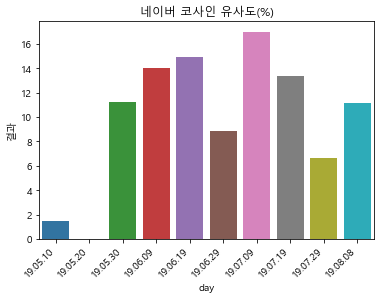

In [114]:
df1=pd.DataFrame({'day':('19.05.10','19.05.20','19.05.30','19.06.09','19.06.19','19.06.29', '19.07.09', '19.07.19', '19.07.29', '19.08.08'),'결과':cos})
p = sns.barplot(data = df1, x ='day',y='결과')
p.set_xticklabels(p.get_xticklabels(), rotation=45, horizontalalignment='right')
p.set_title("네이버 코사인 유사도(%)")